# XAI - Water Quality in Brisbane


Research question: How can machine learning models predict Dissolved Oxygen levels in water, and what factors most influence these predictions?

## Read and clean dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/brisbane_water_quality.csv')

In [156]:
df.describe()

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
count,30894.000000,30874.000000,30893.000000,30309.000000,30086.000000,25730.000000,25550.000000,26594.000000,26370.000000,25145.000000,24944.000000,29810.000000,29586.0,26936.000000,26712.0,29527.000000,29303.0,28894.000000,28670.0
mean,16914.500000,16.799189,177.544711,2.782251,1020.006648,24.415394,1021.673973,6.815158,1020.488055,96.641207,1022.976668,8.063260,1020.0,31.003265,1020.0,47.927487,1020.0,3.941688,1020.0
std,8918.473945,13.168964,103.621786,1.859404,1.153049,3.494728,40.599400,0.620860,21.976218,8.108339,54.204781,0.091714,0.0,3.469102,0.0,5.155305,0.0,4.072715,0.0
min,1468.000000,0.000000,0.000000,0.100000,1020.000000,17.000000,1020.000000,3.030000,1020.000000,51.836000,1020.000000,7.309000,1020.0,0.057000,1020.0,0.021000,1020.0,0.335000,1020.0
25%,9191.250000,6.594250,86.314000,1.451000,1020.000000,21.292000,1020.000000,6.387000,1020.000000,92.226000,1020.000000,7.980000,1020.0,29.151000,1020.0,45.046000,1020.0,2.354250,1020.0
50%,16914.500000,13.390500,176.326000,2.371000,1020.000000,25.245500,1020.000000,6.814000,1020.000000,96.513000,1020.000000,8.073000,1020.0,30.603500,1020.0,47.420000,1020.0,3.093000,1020.0
75%,24637.750000,23.600000,267.870000,3.650000,1020.000000,27.254000,1020.000000,7.254000,1020.000000,101.668000,1020.000000,8.140000,1020.0,33.918000,1020.0,53.361000,1020.0,4.005000,1020.0
max,32361.000000,89.912000,359.994000,43.301000,1220.000000,32.063000,2010.000000,9.260000,2010.000000,134.082000,2010.000000,8.255000,1020.0,36.000000,1020.0,54.996000,1020.0,49.869000,1020.0


In [3]:
# [quality] columns contain metadata about the quality of the measurement. We however do not have access to what the specific codes actually mean.
# Therefore they have no use to us in this analysis, and we therefore drop them.

df = df.drop(columns=[col for col in df.columns if '[quality]' in col])


In [4]:
# Ensure that Timestamp column is of datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [5]:
# Set Timestamp as index
df = df.set_index('Timestamp')

In [ ]:
# There are some timestamps where there are multiple measurements (duplicates). 
# We simply drop the duplicate measurements, using a "first wins" approach

print("Before removing duplicates: ", df.shape)

df = df[~df.index.duplicated(keep='first')]

print("After removing duplicates: ", df.shape)


Before removing duplicates:  (30894, 11)
After removing duplicates:  (30614, 11)


In [161]:
# All columns should now have the correct datatype (datetime timestamp, int record number, all other are floats)
df.dtypes

Record number                       int64
Average Water Speed               float64
Average Water Direction           float64
Chlorophyll                       float64
Temperature                       float64
Dissolved Oxygen                  float64
Dissolved Oxygen (%Saturation)    float64
pH                                float64
Salinity                          float64
Specific Conductance              float64
Turbidity                         float64
dtype: object

In [162]:
# For some measurements, the values are missing (nan).
print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")

Total number of rows: 30614
Number of rows without any NaN values: 19212


In [7]:
# We have two strategies for handling missing (nan) values:
#   1. Drop the rows with missing data values (reducing records in dataset by around 1/3)
#   2. Use some technique to fill in missing data, like interpolation.
#       This is a common technique used in time series analysis to fill missing values in time series data. 

# We create dataframes with both strategies

df_drop = df.dropna()
df_interpolate = df.interpolate(method='time')

In [164]:
# Now all rows have values for all columns

print(f"Total number of rows (drop): {df_drop.shape[0]}")
print(f"Number of rows without any NaN values (drop): {df_drop.dropna().shape[0]}")

print(f"Total number of rows (interpolated): {df_interpolate.shape[0]}")
print(f"Number of rows without any NaN values (interpolated): {df_interpolate.dropna().shape[0]}")

Total number of rows (drop): 19212
Number of rows without any NaN values (drop): 19212
Total number of rows (interpolated): 30614
Number of rows without any NaN values (interpolated): 30614


In [8]:
# To simplify the code (avoiding having to passing around two dataframes, two sets of test data etc.),
#   we switch what dataframe we use, with a simple boolean flag. Results for both datasets are included in report.

USE_INTERPOLATED_DATAFRAME = True

df = df_interpolate if USE_INTERPOLATED_DATAFRAME else df_drop

In [166]:
# For some of the models (xgboost) we want to explore the impact of lag features
# We add 3 lag features for target 'Dissolved Oxygen', by shifting by 1, 2 and 3, respectively.

df['DO_lag1'] = df['Dissolved Oxygen'].shift(1)
df['DO_lag2'] = df['Dissolved Oxygen'].shift(2)
df['DO_lag3'] = df['Dissolved Oxygen'].shift(3)

# First 3 rows will not have complete data (NaN values for at least one of the lag features). 
# We simply drop these 3 rows

df = df.dropna()

print(f"Total number of rows: {df.shape[0]}")
print(f"Number of rows without any NaN values: {df.dropna().shape[0]}")



Total number of rows: 30611
Number of rows without any NaN values: 30611


## Exploratory Data Analysis

We do some exploratory data analysis (using the interpolated dataframe)

In [167]:
df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,DO_lag1,DO_lag2,DO_lag3
Timestamp,,,,,,,,,,,,,,
2023-08-05 00:30:00,1476,2.982,93.117,1.433,19.804,7.446,100.471,8.166,35.273,53.339,1.995,7.459,7.455,7.472
2023-08-05 01:00:00,1477,9.851,53.062,1.499,19.770,7.454,100.515,8.168,35.283,53.353,1.973,7.446,7.459,7.455
2023-08-05 01:30:00,1478,3.370,318.489,1.083,19.741,7.447,100.371,8.167,35.290,53.362,2.014,7.454,7.446,7.459
2023-08-05 02:00:00,1479,0.283,324.385,1.001,19.712,7.426,100.038,8.170,35.292,53.365,1.845,7.447,7.454,7.446
2023-08-05 02:30:00,1480,4.989,166.410,1.435,19.711,7.404,99.745,8.169,35.290,53.363,1.861,7.426,7.447,7.454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,6.796,7.155,7.004
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,6.876,6.796,7.155
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,6.918,6.876,6.796


### Plot oxygen levels, by time

In [15]:
# Create columns for each unique month, and day.

plot_df = df.copy()

plot_df['Year-Month'] = plot_df.index.to_period('M').astype(str)
plot_df['Year-Month-Day'] = plot_df.index.to_period('D').astype(str)

In [16]:
plot_df

,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,Year-Month,Year-Month-Day
Timestamp,,,,,,,,,,,,,
2023-08-04 23:00:00,1468,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068,2023-08,2023-08-04
2023-08-04 23:30:00,1469,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994,2023-08,2023-08-04
2023-08-05 00:00:00,1475,9.138,52.005,1.443,19.822,7.459,100.667,8.159,35.271,53.337,2.033,2023-08,2023-08-05
2023-08-05 00:30:00,1476,2.982,93.117,1.433,19.804,7.446,100.471,8.166,35.273,53.339,1.995,2023-08,2023-08-05
2023-08-05 01:00:00,1477,9.851,53.062,1.499,19.770,7.454,100.515,8.168,35.283,53.353,1.973,2023-08,2023-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 08:20:00,32357,13.314,82.720,0.944,18.607,6.876,87.556,8.151,29.268,45.134,3.963,2024-06,2024-06-27
2024-06-27 08:30:00,32358,32.617,18.081,1.161,18.551,6.918,87.987,8.163,29.254,45.115,3.928,2024-06,2024-06-27
2024-06-27 08:40:00,32359,8.552,306.184,1.192,18.558,6.651,84.606,8.145,29.250,45.110,4.097,2024-06,2024-06-27


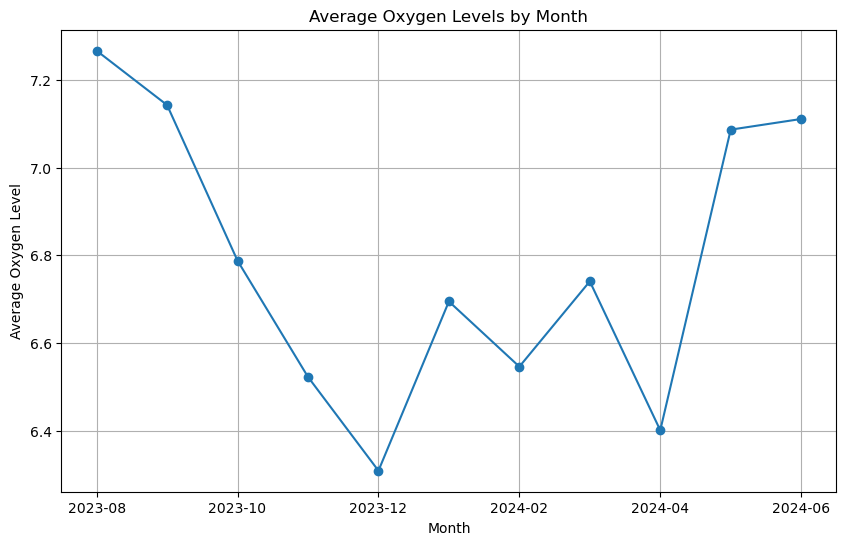

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by month and calculate the mean Dissolved Oxygen for each month
monthly_oxygen_levels = plot_df.groupby('Year-Month')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
monthly_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Month')
plt.xlabel('Month')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

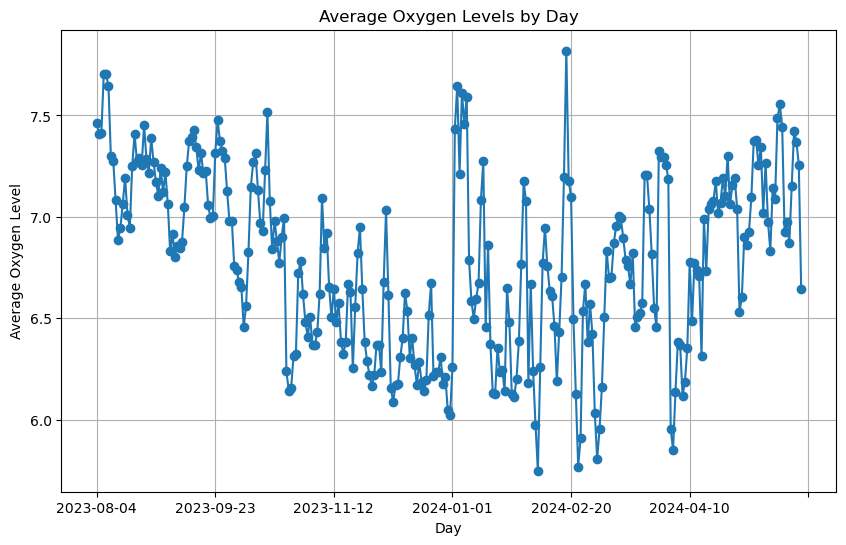

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by day and calculate the mean Dissolved Oxygen for each day
daily_oxygen_levels = plot_df.groupby('Year-Month-Day')['Dissolved Oxygen'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
daily_oxygen_levels.plot(kind='line', marker='o')
plt.title('Average Oxygen Levels by Day')
plt.xlabel('Day')
plt.ylabel('Average Oxygen Level')
plt.grid(True)
plt.show()

### Features correlated with oxygen

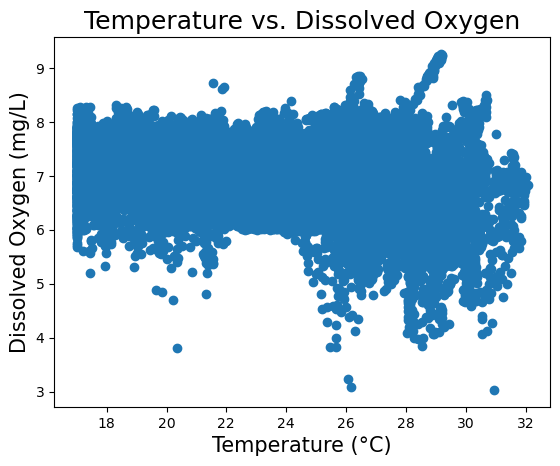

In [19]:
#plot 1: How tamperature affects Dissolved Oxygen
plt.scatter(df['Temperature'], df['Dissolved Oxygen'])
plt.xlabel ('Temperature (°C)', size=15)
plt.ylabel ('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Temperature vs. Dissolved Oxygen', size=18)
plt.show()

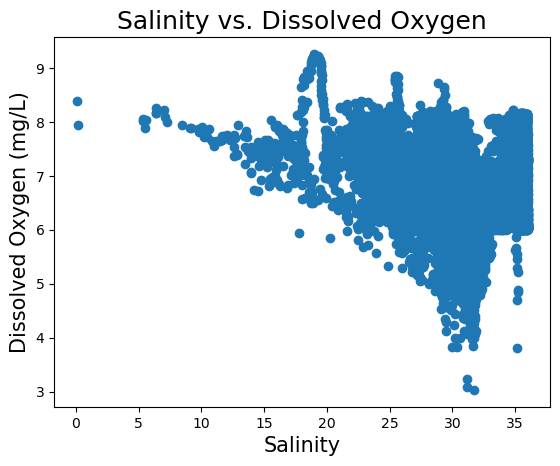

In [20]:
plt.scatter(df['Salinity'], df['Dissolved Oxygen'])
plt.xlabel ('Salinity', size =15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title ('Salinity vs. Dissolved Oxygen', size=18)
plt.show()

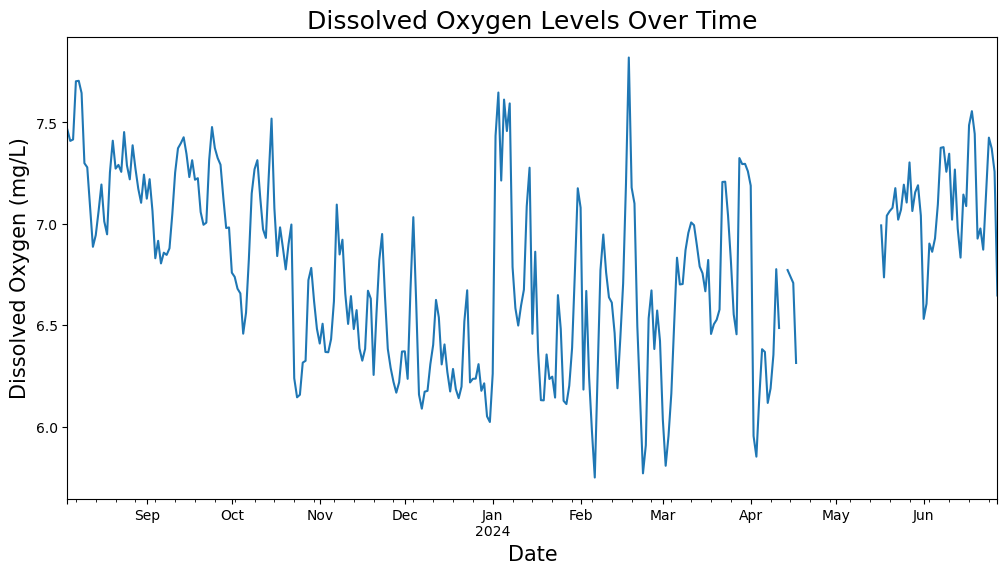

In [21]:
df.resample('D').mean()['Dissolved Oxygen'].plot(figsize=(12,6))
plt.xlabel('Date', size=15)
plt.ylabel('Dissolved Oxygen (mg/L)', size=15)
plt.title('Dissolved Oxygen Levels Over Time', size=18)
plt.show()

### Correlation Matrix

In order to investigate how different features of the dataset relates eachother, we can create a correlation matrix.

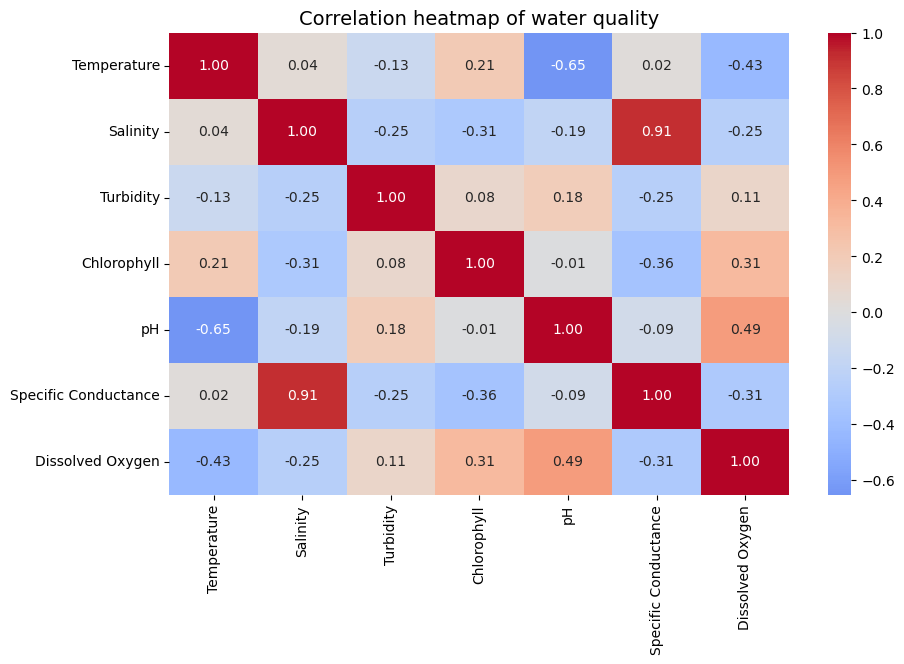

In [22]:
import seaborn as sns

features =[ "Temperature", "Salinity", "Turbidity", "Chlorophyll", "pH", "Specific Conductance", "Dissolved Oxygen" ]

correlation_matrix = df[features].corr()

#Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation heatmap of water quality", fontsize=14)
plt.show()

A positive correlation (closer to +1), that indicates the one feature increases, the other increases. For example

While the negative correlation (closer to -1) means that as one feature increases, the other decreases. For instance, higher tempratures is likely reduced dissolved oxygen levels.

A correlation close to 0 suggest that it is a weak or no relashionship between the features, meaning that changes in one feture do not significantly affect the other.

## Model

1. 2/ Autoregressive Integrated Moving Average (ARIMA)- mest kjent
2. Seasonal Autoregressive Integrated Moving-Average (SARIMA)
3. 3/ Long Short-Term Memory (LSTM): Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. It is often used to solve time series forecasting problems.

Forecasting evaluation involves metrics like scale-dependent errors such as Mean squared error(MSE) and Root mean squared error (RMSE), Percentage errors such as Mean absolute percentage error (MAPE), Scaled errors such as Mean absolute scaled error (MASE) to mention a few. These metrics are actually similar to static ML metrics. 

In [169]:
from sklearn.model_selection import train_test_split

# X are features. 
# We remove Dissolved Oxygen (target) and Dissolved Oxygen (%Saturation), as it is a derived value.
# We also remove RecordNumber as it is just an index.

X = df.drop(columns=['Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)', 'Record number'])
# Y are the target value - we want to predict amount of Dissolved Oxygen
y = df['Dissolved Oxygen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We want to only allow xgboost model to access the lag features
X_train_xgb, X_test_xgb = X_train, X_test

X_train = X_train.drop(columns = ['DO_lag1', 'DO_lag2', 'DO_lag3'])
X_test = X_test.drop(columns = ['DO_lag1', 'DO_lag2', 'DO_lag3'])

#### Linear Regression

In [24]:
from sklearn.linear_model  import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

#### Random Forest Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### XGBoost

In [170]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train_xgb, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

#### Neural Network - LSTM(RNN)

In [105]:
# We suspected that LSTM neural network will only work well using input in chronological order - therefore having to avoid shuffling the data

# We therefore tried using a chronologically sorted training and test set - splitting manually on 80%. 

# This however did not improve the performance of the model - it also negatively impacted the results of the other models.

# split_index = int(len(df) * 0.8)
# X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
# y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Constants for training of model

SEQUENCE_LENGTH = 48

HIDDEN_SIZE = 64  # Number of features in the hidden state
NUM_LAYERS = 2  # Number of LSTM layers

NUM_EPOCHS = 50

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Structure as 3D tensors for LSTM input
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])  # Sequence of `sequence_length` time steps
        y.append(target[i + sequence_length])   # Target is the next value
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.to_numpy(), SEQUENCE_LENGTH)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.to_numpy(), SEQUENCE_LENGTH)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32).view(-1, 1)  # Reshape for compatibility
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for regression

    def forward(self, x):
        # Forward propagate through LSTM
        x, _ = self.lstm(x)  # No need to unsqueeze, input should already be 3D

        # unpack
        x = x[:, -1, :]

        # Pass the last time step's output to the fully connected layer
        x = self.fc(x)

        return x
    
    # Add a predict method
    def predict(self, X):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            X_seq, _ = create_sequences(X.to_numpy(), np.zeros(len(X)), SEQUENCE_LENGTH)
            X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # Convert input to tensor
            predictions = self(X_tensor)  # Forward pass
        return predictions.numpy()  # Convert predictions to NumPy array


# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model_lstm = LSTMNetwork(input_size, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the model
for epoch in range(NUM_EPOCHS):
    model_lstm.train()
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model_lstm(batch_X)
        loss = criterion(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}")

# Evaluate the model on the test set
model_lstm.eval()
with torch.no_grad():
    test_predictions = model_lstm(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")

Epoch 1/50, Loss: 0.20615877211093903
Epoch 2/50, Loss: 0.26466819643974304
Epoch 3/50, Loss: 0.2631562054157257
Epoch 4/50, Loss: 0.2845337390899658
Epoch 5/50, Loss: 0.38540828227996826
Epoch 6/50, Loss: 0.42290207743644714
Epoch 7/50, Loss: 0.48989593982696533
Epoch 8/50, Loss: 0.3215028643608093
Epoch 9/50, Loss: 0.42172229290008545
Epoch 10/50, Loss: 0.4519975781440735
Epoch 11/50, Loss: 0.31253474950790405
Epoch 12/50, Loss: 0.5164784789085388
Epoch 13/50, Loss: 0.47207146883010864
Epoch 14/50, Loss: 0.47180458903312683
Epoch 15/50, Loss: 0.2910376191139221
Epoch 16/50, Loss: 0.3419734835624695
Epoch 17/50, Loss: 0.33898335695266724
Epoch 18/50, Loss: 0.42216384410858154
Epoch 19/50, Loss: 0.4011799097061157
Epoch 20/50, Loss: 0.2850785553455353
Epoch 21/50, Loss: 0.38428789377212524
Epoch 22/50, Loss: 0.33542054891586304
Epoch 23/50, Loss: 0.3853056728839874
Epoch 24/50, Loss: 0.44752347469329834
Epoch 25/50, Loss: 0.3354913592338562
Epoch 26/50, Loss: 0.32566410303115845
Epoch 

## Evalute model against test data

In [174]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error


def eval_model(model, X=None, trim_sequence_length=False):
    X = X if X is not None else X_test
    
    # Make predictions on the test set
    y_pred = model.predict(X)

    y = y_test if not trim_sequence_length else y_test[SEQUENCE_LENGTH:] 

    # Calculate Mean Absolute Error (MAE)
    r2 = r2_score(y, y_pred)
    print(f'R2 score: {r2}')

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, y_pred)
    print(f'Mean Absolute Error: {mae}')

    # Calculate Root Squared Error (MSE)
    rmse = root_mean_squared_error(y, y_pred)
    print(f'Root Mean Squared Error: {rmse}')
    
    return {
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    
   

In [28]:
results = {}

In [29]:
results["Linear Regression"] = eval_model(model_lr)

R2 score: 0.4613552128327576
Mean Absolute Error: 0.35408846784937514
Root Mean Squared Error: 0.4675829132456852


In [30]:
results["Random Forest"] = eval_model(model_rfr)

R2 score: 0.8845612189440507
Mean Absolute Error: 0.14609559082779994
Root Mean Squared Error: 0.21646279808135666


In [175]:
results["XGBoost"] = eval_model(model_xgb, X=X_test_xgb)

R2 score: 0.9348050612616271
Mean Absolute Error: 0.10008225819549844
Root Mean Squared Error: 0.16253013790845025


In [118]:
results["LSTM"] = eval_model(model_lstm, trim_sequence_length=True)

R2 score: -0.017305504300541452
Mean Absolute Error: 0.5216633824221182
Root Mean Squared Error: 0.6422093509775745


In [31]:
# Create DataFrame from results
results_df = pd.DataFrame.from_dict(results, orient='index')  # Transpose so models are rows
results_df = results_df.round(4)  # Round for readability

print(results_df)

                       R²     MAE    RMSE
Linear Regression  0.4614  0.3541  0.4676
Random Forest      0.8846  0.1461  0.2165


## XAI Methods

### Shap (Shapley Additive Explanations)


In [32]:
import shap
shap.initjs()

#### ***Linear Regression and SHAP***

In [33]:
#We use SHAP's Linear Explainer for our Linear Regression model
#because it's specifically designed to work with linear models.
 
explainer = shap.Explainer(model_lr, X_train) #Dont need to specify the explainer, since the new SHAP API does it automatically 
shap_values = explainer(X_test)

##### Global Plots

In [34]:
#Global Force plot

sample = shap.utils.sample(shap_values,1000,random_state=1)
shap.plots.force(sample)

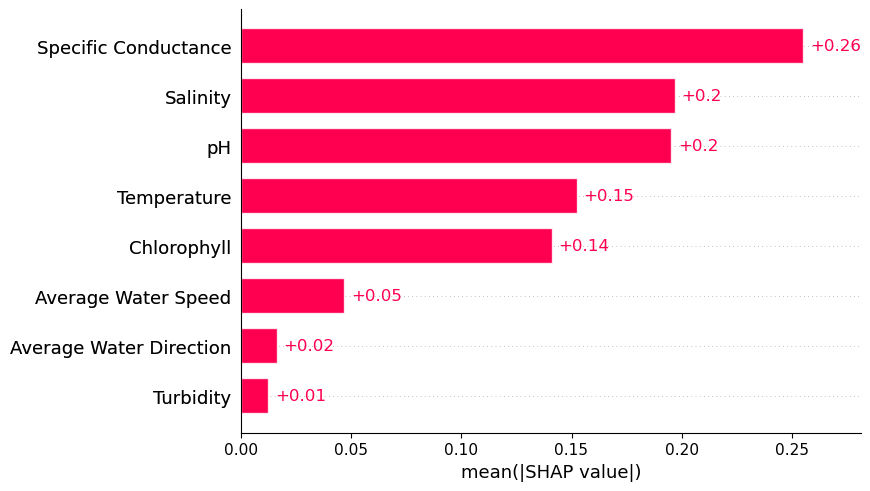

In [35]:
#Bar 
shap.plots.bar(shap_values)

The SHAP bar plot above only shows how much a feature contributes on average (the magnitude), but not the direction (increase or decrease). 

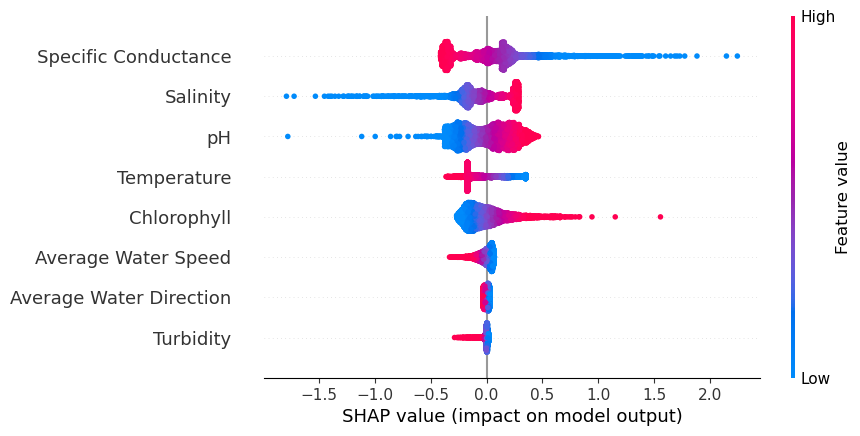

In [36]:
#Beeswarm
shap.plots.beeswarm(shap_values)

The beeswarm plot there by as shown above, tell us how a feature increses or decreases. If most red dots for "pH" are on the right, then high pH increases DO predictions. If they are on the left, hihg pH decreases DO.   

We have also visualized the ***Dependence Plot*** of each feature below inorder to see if the SHAP values of one feature changes differently at different values of another features. We chose to compare the top-5 features from the SHAP bar plot with eachother. The X-asis are the feature values while y-axis are SHAP values. 

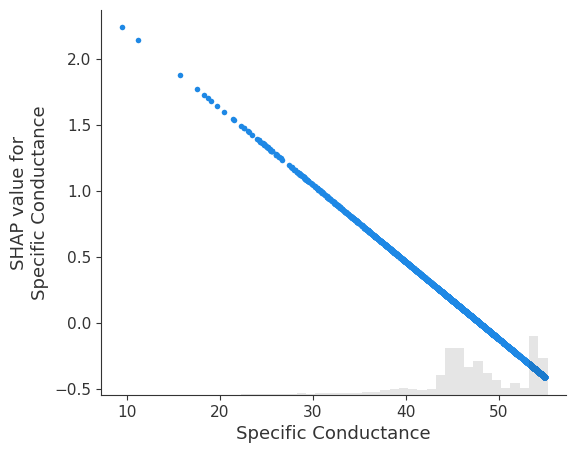

In [37]:
#Dependence Plot

#Specific Conductance
shap.plots.scatter(shap_values[:,'Specific Conductance'])

The plot above tell us that as Specific Conductance increases, the predicted DO decreases. Higher Specific Conductance -> Lower DO prediction. 

If we refer back to the bar plot earlier, this feature had the strongest overall impact on the model's output. However, with the impact being consistently negative. 

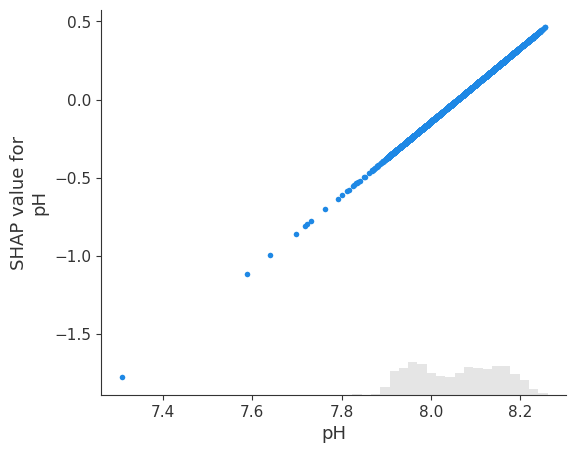

In [38]:
#pH
shap.plots.scatter(shap_values[:,'pH'])

The dependence plot above tell us that as pH increases, the SHAP value for pH increases as well. Which means that higher pH consistently increases the predicted DO level. 

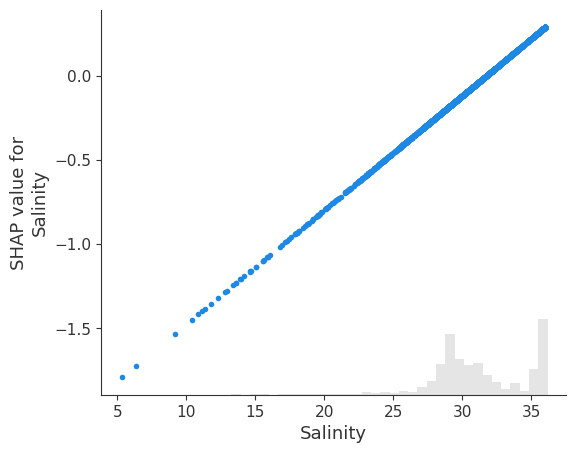

In [39]:
#Salinity
shap.plots.scatter(shap_values[:,'Salinity'])

This plot of Salinity above definitely suprised us, because apparently from what we read in ***Atlas Scientific***, as salinity increases, dissolved oxygen exponentially decreases. Because saltwater holds less oxygen than freshwater. While the plot above tells us an opposite story. 

Since the data is showing us a local trend, we assume that the salinity might correlate with other features in our samples. For instance cooler temperatures or higher pH/ chlorophyll which can increase DO. So the model might assign salinity a positive SHAP effect, even if its not the true driver.

- Source:
https://atlas-scientific.com/blog/dissolved-oxygen-and-salinity/ 

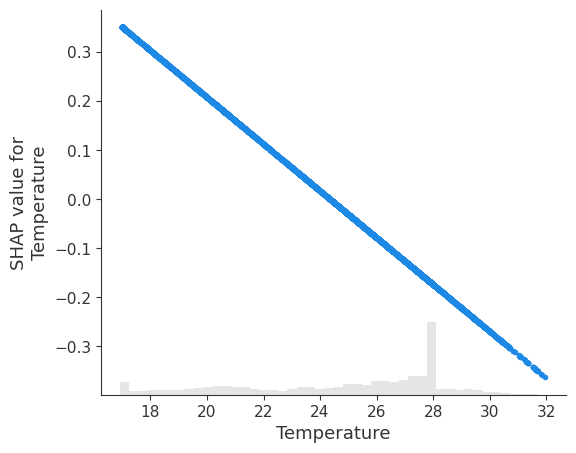

In [40]:
#Temperature 
shap.plots.scatter(shap_values[:,'Temperature'])

The plot above tells us that the temperature feature pulls predictions lower when it increases, across samples. According to ***Atlas Scientific***, oxygen solubility decreases with increasing temperatures.

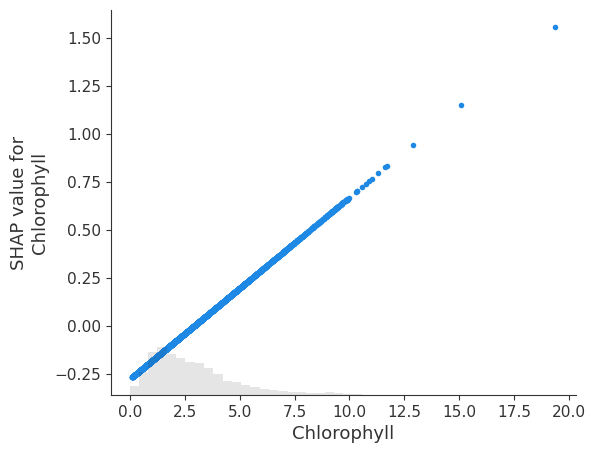

In [41]:
#Chlorophyll
shap.plots.scatter(shap_values[:,'Chlorophyll'])

This plot aligns with verified scientific sources aswell, which suggests that more chlorophyll increases DO. 

Chlorophyll is associated with algae and photosynthetic activity which leads more oxygen being produced, during daylight atleast. 

In order to understand the result of Dependence plot of Salinity, we wanted to use the color= shap_ values inorder to understand Salinity's interaction with other features. For instance, to check if Salinity increases because temperature is low. 

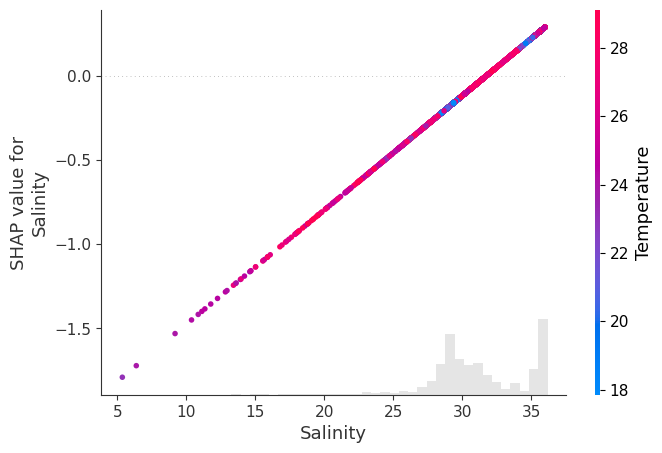

In [42]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"Temperature"])

The plot above is quite similar to the dependence plot, but it adds Temperature feature as the interaction color which reveals the relationship between Salinity and Temperature. 

The relationship between Salinity and SHAP value in linear as in the plot earlier with the color gradient also being evenly distributed along the line without distinct bands or curves. 

The effect of Salinity on DO prediction is roughly the same whether the water is warm or cool. It could be that the model learned that higher Salinity correlates with higher DO, and this trend holds across different temperatures. But we cant be sure until we check Salinity's interaction with other features. 

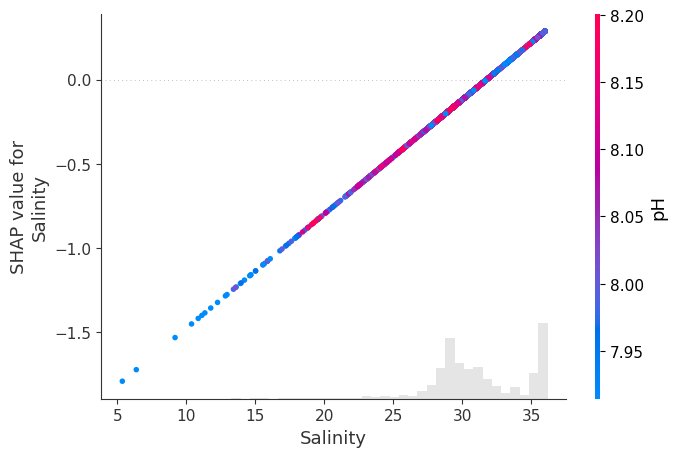

In [43]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"pH"])

We explored how pH might interact with Salinity when predicting dissolved oxygen (DO). The colors were evenly distributed, however salinity had a negative effect on DO predictions,when pH was lower (the blue color dots at the bottom). Which makes sense scitifically because pH levels can affect how aquatic systems handle gases like CO2 and O2 and higher pH is often a sign of active photosynthesis. 

So if pH is higher, there might be more oxygen in the water, which could reduce how strongly salinity pulls Do levels down. 

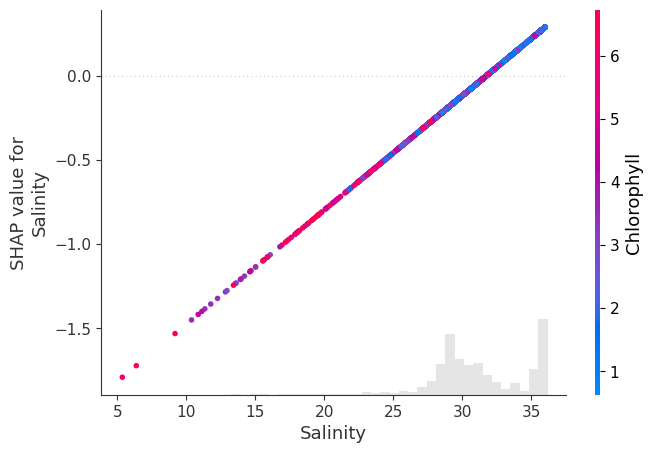

In [44]:
shap.plots.scatter(shap_values[:,"Salinity"], color=shap_values[:,"Chlorophyll"])

In the plot above, we ahve introduced Chlorophyll as an interaction feature in the SHAP dependence plot for Salinity. Since Higher Chlorophyll increased the DO predicitons, we wanted to check how the different levels were correlated with Sanity levels. 

Interestingly, we observed that the positive effect of Salinity weakened and in some case reversed when Chlorophyll levels were high. This suggests that while Salinity may be associated with higher DO in general, its effect is context-dependent. Specifically, in conditions with elevated Chrolophyll, Salinity may be contributing to lower DO predictions. 

Easily put: Salinity increased DO predictions, but for the samples where this happened, Chrolophyll levels were mostly low. While when Chrolophyll was high, Salinity`s positive effect was weaker or evn negative. 

However its also important to note that, there are also samples where the Salinity SHAP value was positive and the Chrolophyll was high. This suggest that our model doesnt apply hard rules, but is rather picking up multi-dimensional patterns

***Possible try outs***

Figure out if the LR model had a main role in detecting patterns which suggested that higher Salinity -> higher DO?

Group-level summary (bonus):

Try grouping samples by low/med/high Salinity

Compare mean DO levels or SHAP values of other features across those groups
➜ This could show indirect effects like:

##### Local Plots

Since our dataframe consists of 30000 samples, we might not be able to run check all the samples locally. However inorder to spot some strong influence or unexpected behavior, we chose to pick samples where DO is either very high or very low. 

In [45]:
#Predictions and Residuals 
y_pred = model_lr.predict(X_test)
residuals = np.abs(y_test.values - y_pred)

In [ ]:
##Getting top samples with extreme predictions
#The argort sorts the predictions from low to high

top_preds = y_pred.argsort()[-5:][::-1]
low_preds = y_pred.argsort()[:5]

#Getting samples with highest prediction error
top_errors = residuals.argsort()[-5:]

#Finding samples where any features has very high SHAP impact
#We will look at the total SHAP values
shap_magnitude = np.abs(shap_values.values).sum(axis=1)
top_total_impact = shap_magnitude.argsort()[-5:]

#Combining all interesting sample indices
interesting_indices = set(top_preds) | set(low_preds) | set(top_errors) | set(top_total_impact)


In [54]:
#Define the groups
group_labels = {}

# Assign group labels to sample indices
for idx in top_preds:
    group_labels[idx] = group_labels.get(idx, []) + ["Highest DO Prediction"]

for idx in low_preds:
    group_labels[idx] = group_labels.get(idx, []) + ["Lowest DO Prediction"]

for idx in top_errors:
    group_labels[idx] = group_labels.get(idx, []) + ["Highest Prediction Error"]

for idx in top_total_impact:
    group_labels[idx] = group_labels.get(idx, []) + ["Most SHAP Influence"]

Sample index: 17 | Group: Highest DO Prediction
Predicted DO: 8.18 | Actual DO: 7.93
Top contributing feature: Specific Conductance (value: 32.588, SHAP: +0.897)

Waterfall plot for this sample:


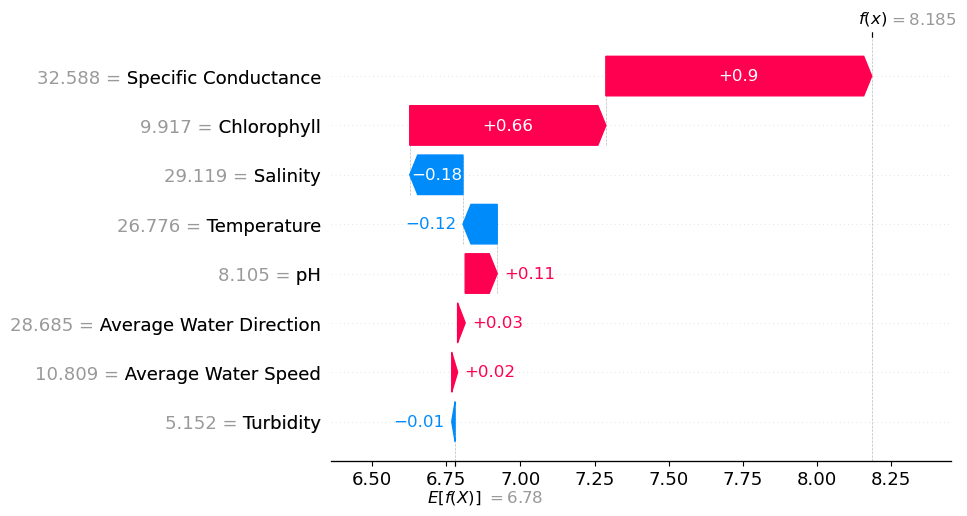

Sample index: 207 | Group: Highest Prediction Error, Most SHAP Influence
Predicted DO: 5.79 | Actual DO: 8.04
Top contributing feature: Specific Conductance (value: 9.544, SHAP: +2.242)

No waterfall plot shown for this sample, summary only.
Sample index: 387 | Group: Lowest DO Prediction
Predicted DO: 5.71 | Actual DO: 4.66
Top contributing feature: pH (value: 7.891, SHAP: -0.399)

No waterfall plot shown for this sample, summary only.
Sample index: 422 | Group: Most SHAP Influence
Predicted DO: 6.32 | Actual DO: 7.65
Top contributing feature: Specific Conductance (value: 18.772, SHAP: +1.703)

No waterfall plot shown for this sample, summary only.
Sample index: 476 | Group: Lowest DO Prediction
Predicted DO: 5.73 | Actual DO: 6.03
Top contributing feature: pH (value: 7.903, SHAP: -0.370)

No waterfall plot shown for this sample, summary only.
Sample index: 872 | Group: Lowest DO Prediction
Predicted DO: 5.77 | Actual DO: 4.13
Top contributing feature: pH (value: 7.816, SHAP: -0.577)


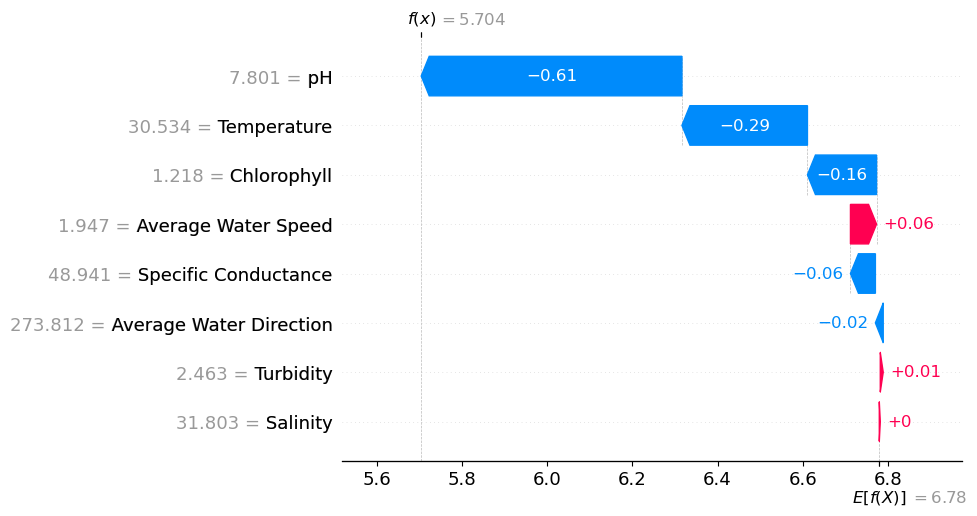

Sample index: 3185 | Group: Highest Prediction Error
Predicted DO: 6.72 | Actual DO: 4.57
Top contributing feature: Chlorophyll (value: 3.844, SHAP: +0.086)

No waterfall plot shown for this sample, summary only.
Sample index: 4294 | Group: Most SHAP Influence
Predicted DO: 6.47 | Actual DO: 8.25
Top contributing feature: Specific Conductance (value: 11.214, SHAP: +2.145)

No waterfall plot shown for this sample, summary only.
Sample index: 4452 | Group: Highest DO Prediction
Predicted DO: 8.08 | Actual DO: 7.99
Top contributing feature: Specific Conductance (value: 33.249, SHAP: +0.858)

No waterfall plot shown for this sample, summary only.
Sample index: 4861 | Group: Highest Prediction Error
Predicted DO: 6.78 | Actual DO: 4.30
Top contributing feature: Salinity (value: 29.522, SHAP: -0.152)

Waterfall plot for this sample:


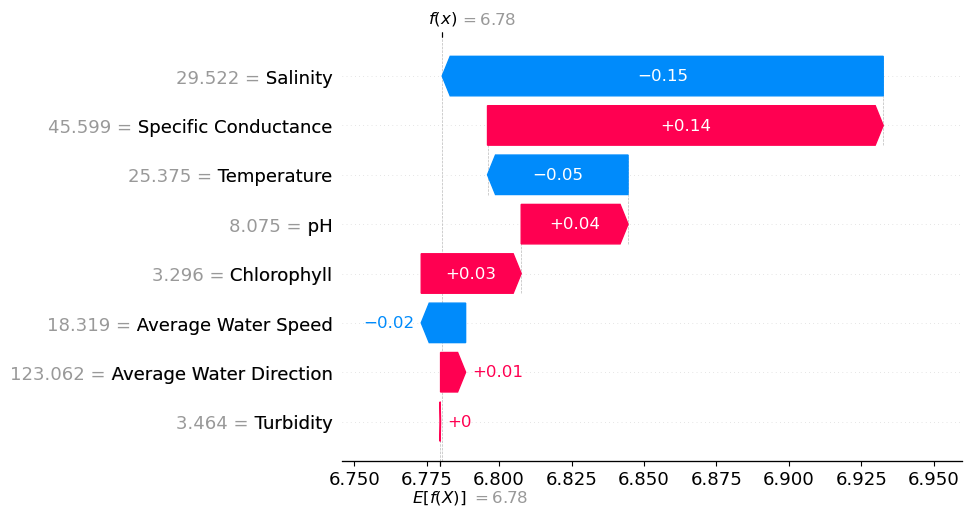

Sample index: 5199 | Group: Most SHAP Influence
Predicted DO: 6.48 | Actual DO: 7.88
Top contributing feature: Specific Conductance (value: 15.724, SHAP: +1.881)

No waterfall plot shown for this sample, summary only.
Sample index: 5449 | Group: Highest Prediction Error
Predicted DO: 6.32 | Actual DO: 4.18
Top contributing feature: Temperature (value: 28.807, SHAP: -0.212)

No waterfall plot shown for this sample, summary only.


In [57]:
#Looping through and displaying one plot from each group, and summarizations of the rest.
plotted = {top_preds[0], low_preds[0], top_errors[-1]}  # show one key sample per group

for i in sorted(group_labels.keys()):
    group = ", ".join(group_labels[i])
    print(f"Sample index: {i} | Group: {group}")
    print(f"Predicted DO: {y_pred[i]:.2f} | Actual DO: {y_test.values[i]:.2f}")

    top_feat_idx = np.argmax(np.abs(shap_values.values[i]))
    top_feat_name = X_test.columns[top_feat_idx]
    top_feat_value = X_test.iloc[i][top_feat_name]
    top_feat_shap = shap_values.values[i][top_feat_idx]

    print(f"Top contributing feature: {top_feat_name} (value: {top_feat_value}, SHAP: {top_feat_shap:+.3f})")
    print("")

    if i in plotted:
        print("Waterfall plot for this sample:")
        shap.plots.waterfall(shap_values[i])
    else:
        print(f"No waterfall plot shown for this sample, summary only.")


Compare two similar samples with different predictions
"Why did these two water samples get different DO predictions?"

#### ***Linear Regression with Coefficients***

In [59]:
coef_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": model_lr.coef_}).sort_values("Coefficient",ascending=False)
print(coef_df)

                   Feature  Coefficient
4                       pH     2.368603
2              Chlorophyll     0.094669
5                 Salinity     0.067774
1  Average Water Direction    -0.000179
0      Average Water Speed    -0.004677
7                Turbidity    -0.006737
3              Temperature    -0.047714
6     Specific Conductance    -0.058403


In [60]:
#Comparing the results above to SHAP global values
#This can tell us whether SHAP and coefficients agree on certain things

coef_df["mean(|SHAP|)"] = np.abs(shap_values.values).mean(axis=0)
coef_df = coef_df.sort_values("mean(|SHAP|)", ascending=False)


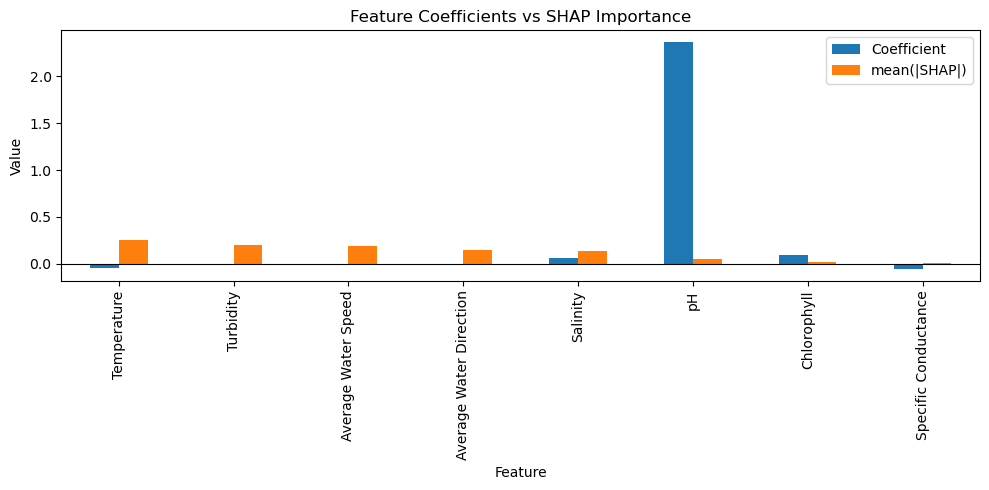

In [62]:
#Visualizing the comparisions
import matplotlib.pyplot as plt

#Plot
coef_df.set_index("Feature")[["Coefficient", "mean(|SHAP|)"]].plot(
    kind="bar", figsize=(10, 5), title="Feature Coefficients vs SHAP Importance"
)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Value")
plt.tight_layout()
plt.show()


#### ***Linear Regression with PDP***

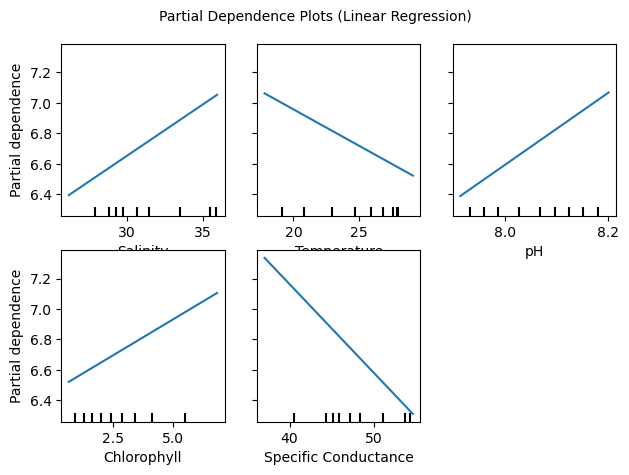

In [68]:
from sklearn.inspection import PartialDependenceDisplay

#Picking top-5 features to analyze, for example based on SHAP global bar
features_to_plot = ["Salinity", "Temperature", "pH", "Chlorophyll", "Specific Conductance"]

PartialDependenceDisplay.from_estimator(
    model_lr, X_train, features=features_to_plot, grid_resolution=50
)

plt.suptitle("Partial Dependence Plots (Linear Regression)", fontsize=10)
plt.tight_layout()
plt.show()


#### Random Forest Regressor

100%|===================| 6175/6179 [11:30<00:00]        

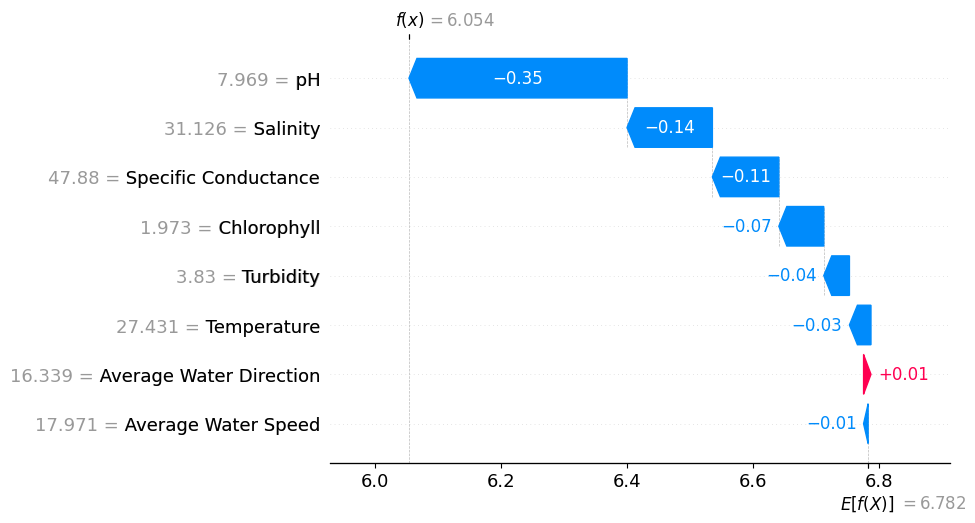

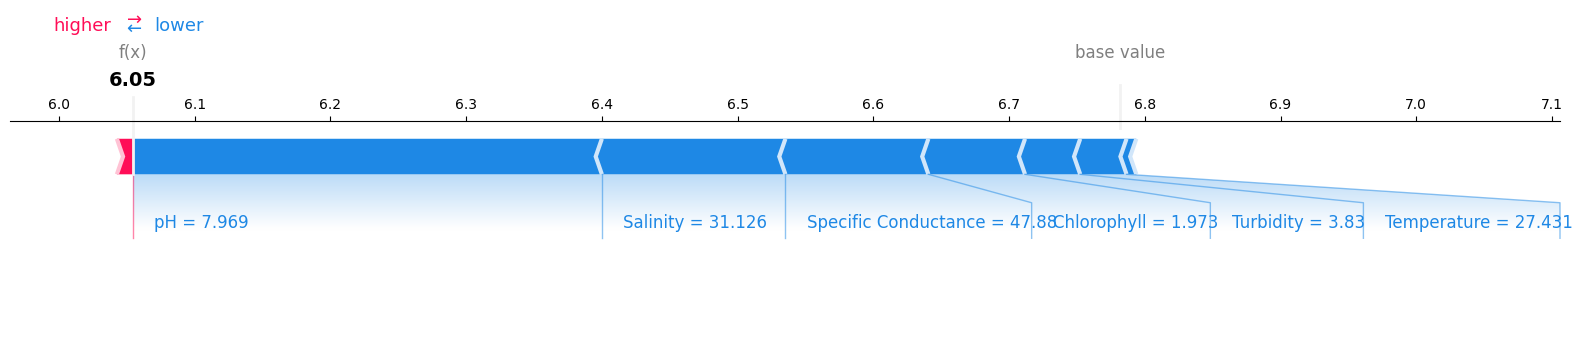

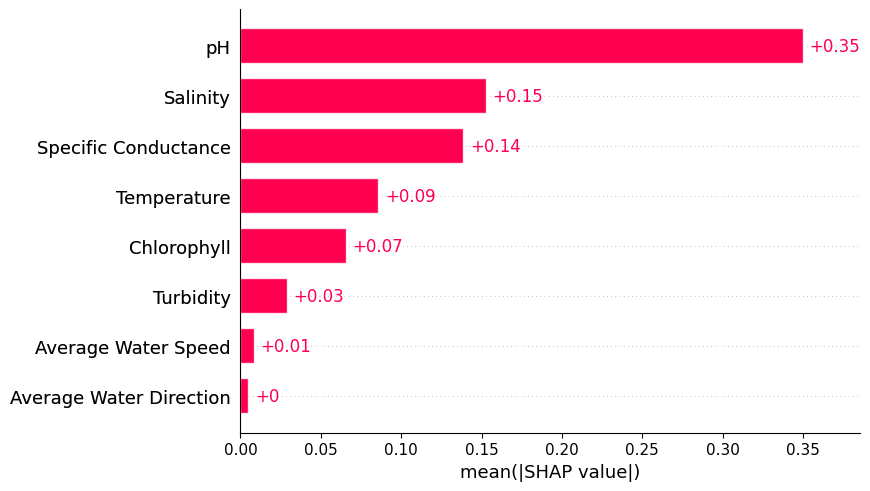

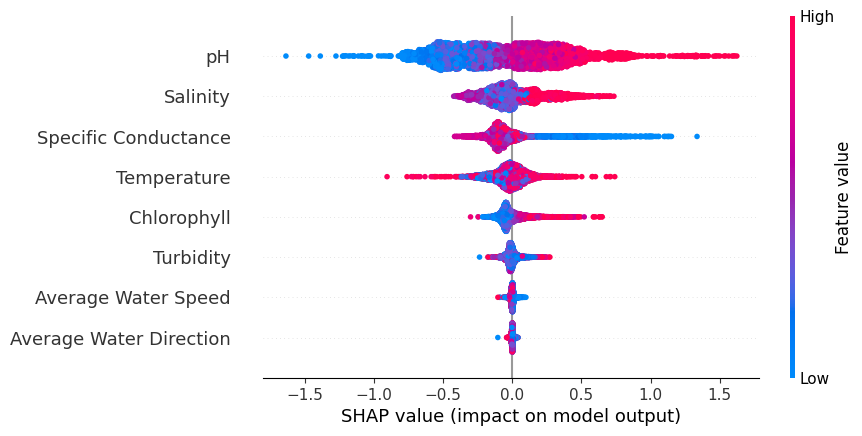

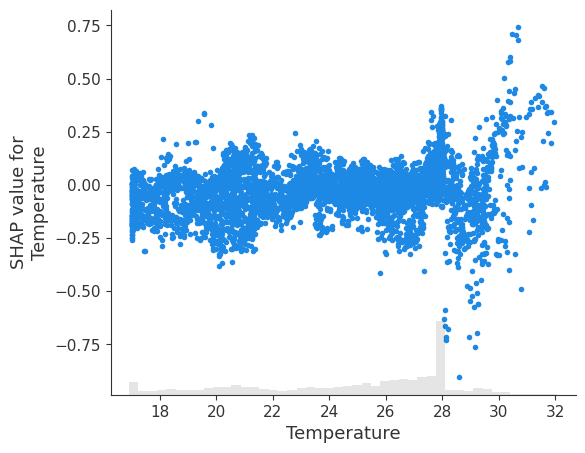

In [64]:
shap_values_rfr = shap_get_values(model_rfr)

shap_local_plot(shap_values_rfr)
shap_global_plot(shap_values_rfr)

### LIME 

### PDP (Partial Dependence Plots)

### For the Linear Regression model

Feature names: ['Temperature', 'Chlorophyll']


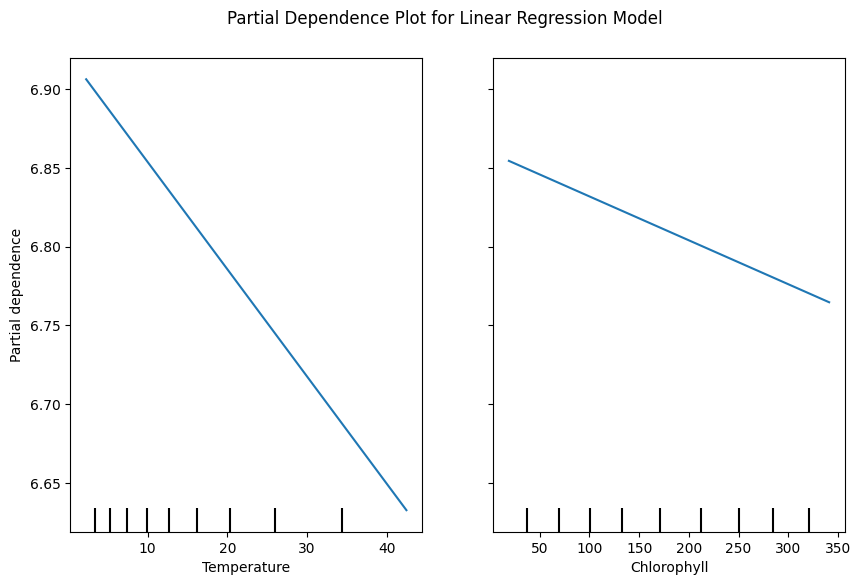

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/brisbane_water_quality.csv') # Load the data
df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Convert Timestamp to datetime
df['Hour'] = df['Timestamp'].dt.hour # Extract hour from Timestamp
df['Day'] = df['Timestamp'].dt.day # Extract day from Timestamp
df['Month'] = df['Timestamp'].dt.month # Extract month from Timestamp


X = df.drop(columns=['Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)', 'Record number', 'Timestamp'])

y = df['Dissolved Oxygen'] # Target variable

non_numeric_columns = X.select_dtypes(exclude=['number']).columns # Get non-numeric columns

if len(non_numeric_columns) > 0: # Check if there are non-numeric columns
    print(f"Warning: non-numeric columns found: {list(non_numeric_columns)}")
    X = X.select_dtypes(include=['number'])


X = X.dropna() # Drop rows with missing values
y = y[X.index] # Filter y to only include rows that are present in X

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Define the features
feature_names = ["Temperature", "Chlorophyll"] # Display names for features

# Check if all required columns are present in the dataset
if not all(col in X_train.columns for col in feature_names):
    missing_columns = [col for col in feature_names if col not in X_train.columns]
    raise ValueError(f"The following required columns are missing: {missing_columns}")


# Replace "Temperature" and "Chlorophyll" with the column names which exist in X
feature_indices = [X_train.columns.get_loc(col) for col in feature_names]

print("Feature names:", feature_names)


# Create PDP for Linear Regression model
fig, ax = plt.subplots(figsize=(10, 6)) # adjust the size as needed here

PartialDependenceDisplay.from_estimator(
    model_lr,
    X_train,
    features=feature_names,
    feature_names=feature_names,  # Add this line to specify display names
    grid_resolution=50,  # resolution of the grid
    ax=ax  # pass the axis we want to plot on
)

plt.suptitle('Partial Dependence Plot for Linear Regression Model', fontsize=12) 
plt.subplots_adjust(top=0.9) 
plt.show() 


## XGBoost

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('../data/brisbane_water_quality.csv') 

df['Timestamp'] = pd.to_datetime(df['Timestamp']) # Convert Timestamp to datetime
df = df.set_index('Timestamp') 

## Lag features 

#### Time-Aware Modeling Prep

In [ ]:
# Create the lag features
def create_lag_features(df, target_column, lags=[1, 2, 3]):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df   

# Create lag features for Dissolved Oxygen
df = create_lag_features(df, 'Dissolved Oxygen', lags=[1, 2, 3])

# Drop rows with NaN values created by lagging
df = df.dropna()

#### Split data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df.drop(columns=['Dissolved Oxygen'])
y = df['Dissolved Oxygen']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the XGBoost models

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train the model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

#### Explain the model with SHAP by visualizing SHAP values

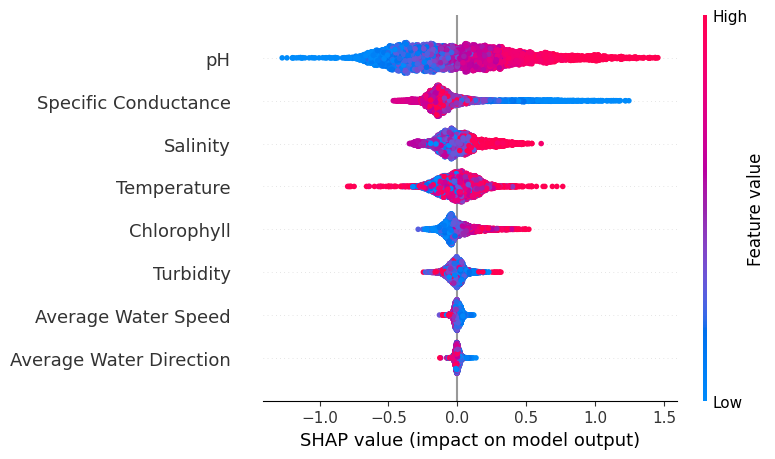

In [59]:
import shap 

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model_xgb)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


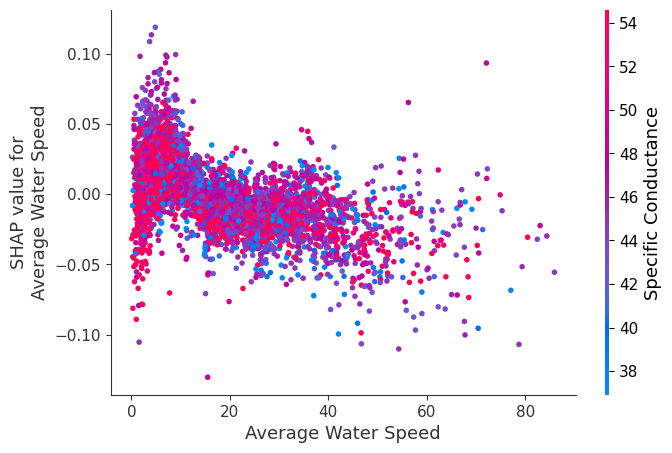

In [60]:
shap.dependence_plot('Average Water Speed', shap_values, X_test)

#### Plot Partial Dependence PDP - showing relationship between a feature and target variable

In [61]:
from sklearn.inspection import plot_partial_dependence

# Plot Partial Dependence Plots for selected features
plot_partial_dependence(model_xgb, X_test, ['Average Water Speed', 'Temperature'])

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (c:\code\eiryll\INFO381\venv\Lib\site-packages\sklearn\inspection\__init__.py)

#### Time series-specific SHAP visualization - SHAP plot over time

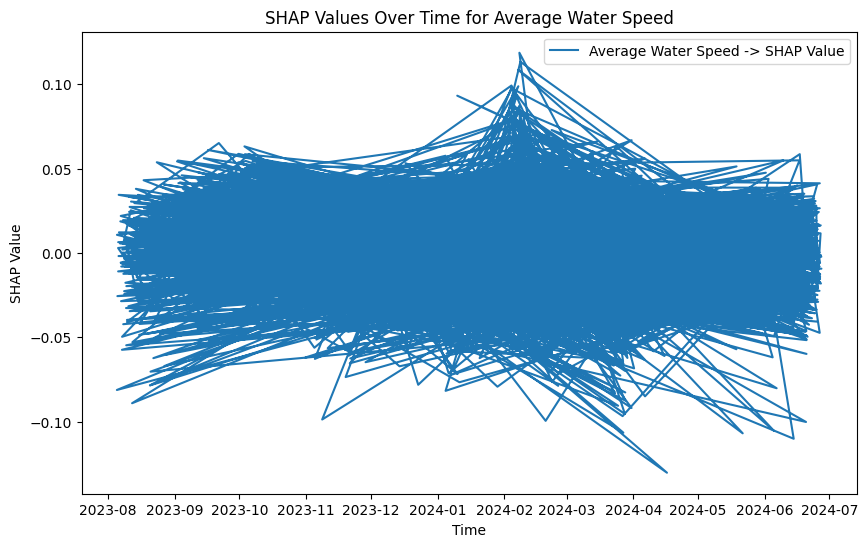

In [63]:
import matplotlib.pyplot as plt

# For specific features, plot the SHAP values over time
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, shap_values[:, X_test.columns.get_loc('Average Water Speed')], label='Average Water Speed -> SHAP Value')
plt.xlabel('Time')
plt.ylabel('SHAP Value')
plt.legend()
plt.title('SHAP Values Over Time for Average Water Speed')
plt.show()

#### Visualize feature importances - XGBoost model and SHAP feature importance

In [64]:
model_xgb.get_booster().feature_names = X_train.columns.to_list()
model_xgb.get_booster().feature_importance(importance_type='weight')

AttributeError: 'Booster' object has no attribute 'feature_importance'

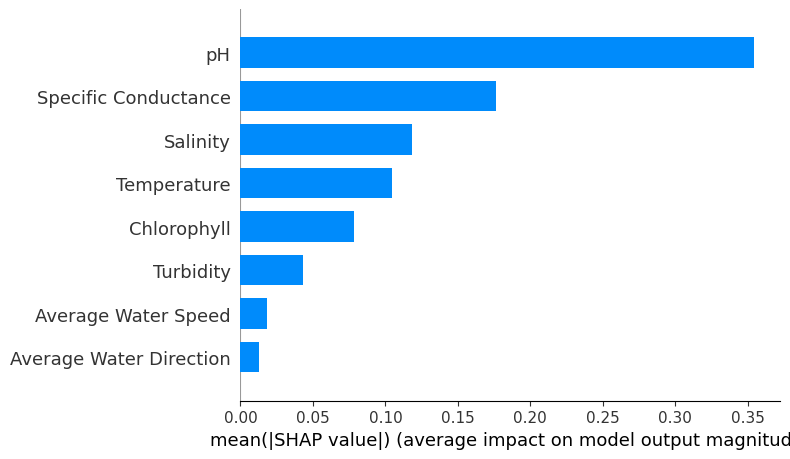

In [65]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

# Random Forest PDP

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay


In [12]:
df = pd.read_csv('../data/brisbane_water_quality.csv') # Load the data

df.head()

# No lag features for Random Forest model


,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
0,2023-08-04 23:00:00,1468,4.834,73.484,1.621,NaN,20.018,NaN,7.472,NaN,101.175,NaN,8.176,NaN,35.215,NaN,53.262,NaN,2.068,NaN
1,2023-08-04 23:30:00,1469,2.544,106.424,1.959,NaN,19.986,NaN,7.455,NaN,100.884,NaN,8.175,NaN,35.209,NaN,53.254,NaN,1.994,NaN
2,2023-08-04 23:00:00,1470,1.260,156.755,1.620,NaN,20.001,NaN,7.430,NaN,100.571,NaN,8.171,NaN,35.207,NaN,53.252,NaN,2.030,NaN
3,2023-08-04 23:30:00,1471,0.760,281.754,1.761,NaN,19.983,NaN,7.419,NaN,100.398,NaN,8.171,NaN,35.211,NaN,53.257,NaN,1.973,NaN
4,2023-08-04 23:00:00,1472,3.397,244.637,1.635,NaN,19.986,NaN,7.429,NaN,100.538,NaN,8.171,NaN,35.208,NaN,53.253,NaN,1.944,NaN


#### Define features and target

In [17]:
target = 'Dissolved Oxygen'
features = [col for col in df.columns if col not in [target, 'Record number', 'Timestamp', 'Year-Month', 'Year-Month-Day']]


#### Split data and train Random Forest

In [18]:
# Split into training and test sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Dropping rows with NaN values in y to ensure compatibility
X_train, y_train = X_train[~y_train.isna()], y_train.dropna()

# Fit the Random Forest Regressor
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

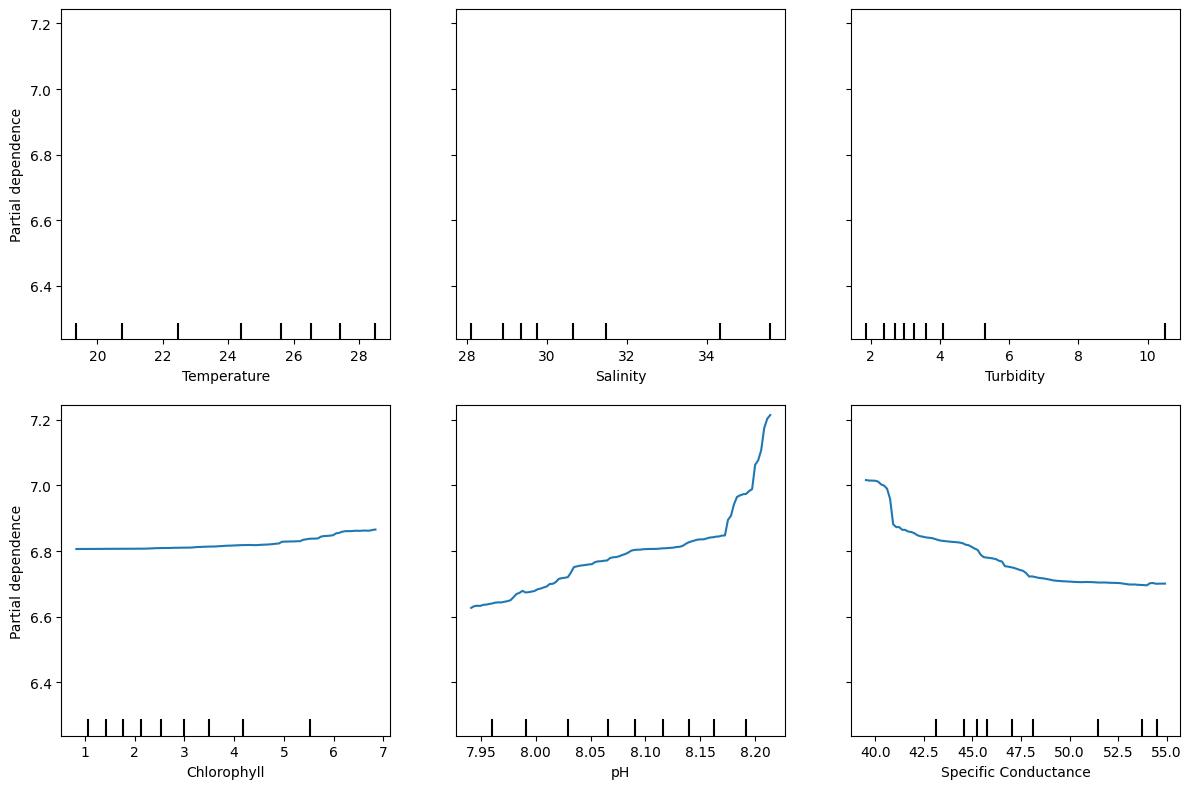

In [21]:
# Partial dependence plots for selected features
features_to_plot = ['Temperature', 'Salinity', 'Turbidity', 'Chlorophyll', 'pH', 'Specific Conductance']
fig, ax = plt.subplots(figsize=(12, 8))

PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train,
    features=features_to_plot,
    kind='average',
    ax=ax
)       

# Display the plots
plt.tight_layout()
plt.show()                   